<a href="https://colab.research.google.com/github/jasper-zheng/teaching/blob/main/Critical_Coding_3_2025/StyleGAN2_network_bending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Bending an Image Generation Model  

###### A tutorial on [Network Bending](https://arxiv.org/abs/2005.12420) (Broad et al., 2021) by [Jasper Shuoyang Zheng](https://jasperzheng.cc/).  

[Network Bending](https://terencebroad.com/research/network-bending) is the art of intervening in the computational graph of a deep learning model during inference. Some examples of network bending to help spur your imagination:

 - Corrupting the weights of a trained model, as in [Mario Klingemann](https://underdestruction.com/2018/12/29/memories-of-passersby-i/) and [Blazej Kotowski](https://www.upf.edu/web/mdm-dtic/blog/-/blogs/network-bending-conducting-operations-on-the-open-bodies-of-neural-nets-by-blazej-kotowski);
 - Adding transformation layers in the model to manipulate the internal representations, as in [Terence Broad](https://terencebroad.com/works/teratome);  
 - Disrupting the way how data is distributed in the latent space, as in [Jasper Zheng](https://jasper-zheng.github.io/nn_terrain/);
 - ... anything else you can imagine!

In this notebook, we'll hack into the inference process of a pre-trained [StyleGAN2](https://github.com/NVlabs/stylegan3) model by applying some arbitrary transformations to the activation maps.  

**Please make sure that you have selected a runtime with a GPU!**

We'll use a pre-trained StyleGAN3 model, the model can be downloaded using the command below:  
(Alternatively, if the command doesn't work, just navigate to the url and download it, place it next to this notebook)

In [ ]:
#@title Installation (only run this once)

# clone the official stylegan repository
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja
!pip install torch==2.7.0 torchvision==0.22.0 torchaudio==2.7.0 --index-url https://download.pytorch.org/whl/cu128

In [ ]:
#@title 01 - Download model, import librarys

import sys

base_dir = 'stylegan3'
sys.path.append(f'{base_dir}')

import torch
import numpy as np

from torchvision.transforms.functional import to_pil_image, affine
from torchvision.utils import make_grid
from torchvision.transforms import InterpolationMode

BILINEAR = InterpolationMode.BILINEAR
NEAREST = InterpolationMode.NEAREST

import matplotlib.pyplot as plt
from IPython.display import display, HTML

import dnnlib
import legacy

source_model_type = 'ffhq' #@param['ffhq', 'metface', 'cat']

source_model_download_path = {"ffhq":   "https://api.ngc.nvidia.com/v2/models/org/nvidia/team/research/stylegan2/1/files?redirect=true\&path=stylegan2-ffhq-1024x1024.pkl",
                              "metface":    "https://api.ngc.nvidia.com/v2/models/org/nvidia/team/research/stylegan2/1/files?redirect=true\&path=stylegan2-metfaces-1024x1024.pkl",
                              "cat":    "https://api.ngc.nvidia.com/v2/models/org/nvidia/team/research/stylegan2/1/files?redirect=true\&path=stylegan2-afhqcat-512x512.pkl"}

model_names = {"ffhq":   "stylegan2-ffhq-1024x1024.pkl",
               "metface":    "stylegan2-metfaces-1024x1024.pkl",
               "cat":    "stylegan2-afhqcat-512x512.pkl"}

model_url = source_model_download_path[source_model_type]
file_name = model_names[source_model_type]



!curl -L 'https://api.ngc.nvidia.com/v2/models/org/nvidia/team/research/stylegan2/1/files?redirect=true&path=stylegan2-ffhq-1024x1024.pkl' -o {file_name}
# !wget --content-disposition {model_url} -O {file_name}


def slerp(val, low, high):
    '''
    original: Animating Rotation with Quaternion Curves, Ken Shoemake
    Code: https://github.com/soumith/dcgan.torch/issues/14, Tom White
    '''
    if len(low.shape) == 1:
        omega = np.arccos(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)))
        so = np.sin(omega)
        return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega)/so * high
    elif len(low.shape) == 2:
        ws = []
        for i in range(low.shape[0]):
            omega = np.arccos(np.dot(low[i,:]/np.linalg.norm(low[i,:]), high[i,:]/np.linalg.norm(high[i,:])))
            so = np.sin(omega)
            w = np.sin((1.0-val)*omega) / so * low[i,:] + np.sin(val*omega)/so * high[i,:]
            ws.append(w)
        return torch.tensor(np.array(ws))

def slerp_interpolation(z1, z2, num_interp):
    # create intervals
    interp_vals = np.linspace(1./num_interp, 1, num=num_interp)

    # Convert latent vectors to numpy arrays
    latent_a_np = z1.cpu().numpy().squeeze()
    latent_b_np = z2.cpu().numpy().squeeze()

    # Create our spherical interpolation between two points
    latent_interp = torch.tensor(np.array([slerp(v, latent_a_np, latent_b_np) for v in interp_vals], dtype=np.float32))
    return latent_interp

def batch_norm(x, min=None, max=None):
    min = x.min() if min is None else min
    max = x.max() if max is None else max
    return (x - min) / (max - min)


device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

print(torch.__version__)
print(f'Using device: {device}')

## 2 - Load a pre-trained model

In [ ]:
network_pkl = file_name

with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)

## 3 - Do a forward pass to generate an image  

Before doing any network bending, let's have a look at how generater in StyleGAN works.  
The generater takes a latent vector $z$ and generates an image corresponding to $z$.   

In [ ]:
truncation_psi = 0.6  # truncation trick allows faces to converge to the “mean” face, if truncation_psi == 0 then you'll always get the “mean” face
c = None   # class labels (not used in this example)
torch.manual_seed(422)

# Generate a random latent vector:
z = torch.randn([1, G.z_dim]).to(device)  # create a (1, 512) shape tensor with random numbers, sampled from a standard normal distribution
print(f'Vector shape: {z.shape}')

Now we can do a regular forward pass and plot the output image  
(if you're on colab running this for the first time, it can take a while... roughly 1~2mins)

In [ ]:
img = G(z, c, truncation_psi=truncation_psi)

print(f'Output shape: {img.shape}')

img = batch_norm(img)
plt.imshow(to_pil_image(img[0].cpu()))
plt.show()

## 4 - Customised forward pass & Visualising activation maps  

Calling the generator `G()` will use the default `forward()` function in PyTorch (see: [PyTorch Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)).   
Instead of using the default one, we can also use write our customised forward pass function, so that we can intervene in the model's inference process.  

However, first we need to know some basics about how the generator in StyleGAN works:  

1. First, our latent vector $z$ is processed by a mapping network, the output is an intermediate style vector $w$, which is a list of 512 dimension vector.
2. Then $w$ is processed by the most important bit is the **synthesis network**: a 8-block convolutional neural network.  
3. The synthesis network starts by a $4\times 4$ noise, each layer scale up the size by 2, so in the end we get a $1024\times 1024$ output.  

Later our "network bending" will operate on the **synthesis network**.

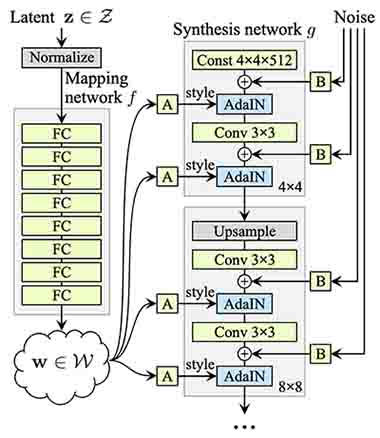


In [ ]:
# Check the model's synthesis blocks
G.synthesis

In our customised forward pass, we can add a `activation_maps` list to keep track of all the internal activation maps.  
We can also print the size of all intermediate tensors.

In [ ]:
def customised_forward_pass(z, truncation_psi, verbose=False):
    # run the mapping network to get the intermediate style vector w
    w = G.mapping(z, None, truncation_psi=truncation_psi).to(torch.float32)
    block_w = []

    # these are some process we need to do to the w... not important
    w_idx = 0
    for res in G.synthesis.block_resolutions:
        block = getattr(G.synthesis, f'b{res}')
        block_w.append(w.narrow(1, w_idx, block.num_conv + block.num_torgb))
        w_idx += block.num_conv

    x = img = None
    activation_maps = []
    # now we run the synthesis network to get the final image output
    # "res" means resolution
    for res, current_w in zip(G.synthesis.block_resolutions, block_w):
        # this is to get the specific block in the synthesis network
        block = getattr(G.synthesis, f'b{res}')

        # run the block,
        x, img = block(x, img, current_w)

        # we keep track of the activation maps
        activation_maps.append(x)

        # print the shape, min and max of the activation map
        if verbose:
            print(f"activation map b{res}: {x.shape} min: {x.min():.4f} max: {x.max():.4f}")

    return img, activation_maps

Let's use our customised forward pass function to generate an image.  
And since we have all activation maps retrieved, we can plot and see how they look like.

In [ ]:
torch.manual_seed(422)
z = torch.randn([1, G.z_dim]).to(device)

# note that you can use the "verbose" argument to stop printing the shapes if you don't want to see them
img, activation_maps = customised_forward_pass(z, truncation_psi, verbose=True)

In [ ]:
plt.figure(figsize=(12,12))
for i in range(len(activation_maps)):
    plt.subplot(len(activation_maps),1,i+1)
    plt.axis('off')
    map_this_block = batch_norm(activation_maps[i].permute(1,0,2,3),min=-2, max=4)
    grid = to_pil_image(make_grid(map_this_block[:20], nrow = 10).cpu().clamp(0,1))
    plt.imshow(grid, cmap='gray')
plt.show()

img = batch_norm(img)
plt.imshow(to_pil_image(img[0].cpu()))
plt.show()

## **Meeting Point 1**  

Before we proceed to the network bending activity, let's pause here and get back to the lecture, we'll talk a bit about transformation layers that can be applied for network bending.

**While you're waiting for others to finish, here are some tasks you can do:**  
 - Change the number in the line `torch.manual_seed(422)`, and re-run the `customised_forward_pass` step to experiment with other random seed;
 - Or, manually adjust some numbers in the `z` variable (the latent vector), and see if you can get some different generation results.


## 5 - Network Bending!  

Now it's time to bend our model.

### 5.1 - Bending the forward pass

Having our customised forward pass means we have full control over the model's inference process.

We can slightly revise our forward pass function, but this time, we can leave some backdoors for inserting transformations in between the network's synthesis blocks.


In [ ]:
def bending_forward_pass(z, truncation_psi, transformations=None, verbose=False):
    # run the mapping network to get the intermediate style vector w
    w = G.mapping(z, None, truncation_psi=truncation_psi).to(torch.float32)
    block_w = []

    # these are some process we need to do to the w... not important
    w_idx = 0
    for res in G.synthesis.block_resolutions:
        block = getattr(G.synthesis, f'b{res}')
        block_w.append(w.narrow(1, w_idx, block.num_conv + block.num_torgb))
        w_idx += block.num_conv

    x = img = None
    activation_maps = []
    # now we run the synthesis network to get the final image output
    for res, current_w in zip(G.synthesis.block_resolutions, block_w):
        # this is to get the specific block in the synthesis network
        block = getattr(G.synthesis, f'b{res}')

        # run the block,
        x, img = block(x, img, current_w)

        # we keep track of the activation maps
        activation_maps.append(x)

        # print the shape, min and max of the activation map
        if verbose:
            print(f"activation map b{res}: {x.shape} min: {x.min():.4f} max: {x.max():.4f}")


        # Right after each synthesis block,
        # we'll add the backdoors for network bending here:
        # --------------------- BENDING ---------------------

        # apply the transformations to the activation map:

        # first, check if we do have the transformations template
        if transformations is None:
            continue # continue means skip the following codes in this for-loop

        # then, check if we have the transformations for this block
        if transformations.get(f'b{res}') is None:
            continue

        # we'll skip the block if there are no transformations
        if len(transformations[f'b{res}']) == 0:
            continue

        # if we made it here, we apply all transformations in this block
        for tf in transformations[f'b{res}']:
            torch.manual_seed(42)
            x = tf(x)

        activation_maps.append(x)

        if verbose:
            print(f"bent b{res}: {x.shape} min: {x.min():.4f} max: {x.max():.4f}")

        # ------------------- BENDING END -------------------

    return img, activation_maps

### 5.2 - Transformation template  

We can insert transformations as Python lambda functions.  
Lambda functions are one-line anonymous functions that can be passed as arguments. More explanations [here](https://www.w3schools.com/python/python_lambda.asp)  


Here is a list of PyTorch transformations we can use as materials:  

In [ ]:
# Basic arithmetic:
# Add
lambda x: x.add(1)
# Multiply
lambda x: x.mul(2)

# Affine transformations (rotate, XY-translate, scale, shear):
# documentation: https://pytorch.org/vision/main/generated/torchvision.transforms.functional.affine.html
lambda x: affine(x, angle=90, translate=[0,0], scale=1, shear=0, interpolation=BILINEAR)

# Noise
# documentation: https://pytorch.org/docs/stable/generated/torch.rand_like.html
lambda x: x + torch.randn_like(x) * 1.0

# Blur via average-pool
# documentation: https://pytorch.org/docs/stable/generated/torch.nn.functional.avg_pool2d.html
# Be careful with the `kernel_size` and `padding` to keep output the same size as input
lambda x: torch.nn.functional.avg_pool2d(x, kernel_size=3, stride=1, padding=1)

# Binary-threshold
# documentation: https://pytorch.org/docs/main/generated/torch.where.html
lambda x: torch.where(x>0, -1.0, 1.0)

The following is a template for transformations,  
Please **add/ change/ remove the codes** below, to create your own network bending template:

In [ ]:
transformations = {
    "b4": [
        # lambda x: # do something here:
        lambda x: x.mul(1.2).add(-0.8),
    ],
    "b8": [
        # lambda x: # do something here:
        lambda x: affine(x, angle=0, translate=[0,1], scale=1, shear=0, interpolation=BILINEAR),
        lambda x: torch.where(x>0, x, 1.0),
    ],
    "b16": [
        # lambda x: # do something here:
        lambda x: x + torch.randn_like(x) * 0.8
    ],
    "b32": [
        # lambda x: # do something here:
        lambda x: affine(x, angle=0, translate=[0,-4], scale=1, shear=0, interpolation=BILINEAR, fill=1.0),
    ],
    "b64": [
        # lambda x: # do something here:
    ],
    "b128": [
        # lambda x: # do something here:
    ],
    "b256": [
        # lambda x: # do something here:
    ],
}

### 5.3 - Test our corrupted network  

Now our network is bent! Do a forward pass to see the result

In [ ]:
torch.manual_seed(422)
z = torch.randn([1, G.z_dim]).to(device)

# note that you can use the "verbose" argument to stop printing the shapes if you don't want to see them
img, activation_maps = bending_forward_pass(z, truncation_psi, transformations=transformations, verbose=True)

In [ ]:
plt.figure(figsize=(12,12))
for i in range(len(activation_maps)):
    plt.subplot(len(activation_maps),1,i+1)
    plt.axis('off')
    map_this_block = batch_norm(activation_maps[i].permute(1,0,2,3),min=-2, max=4)
    grid = to_pil_image(make_grid(map_this_block[:20], nrow = 10).cpu().clamp(0,1))
    plt.imshow(grid, cmap='gray')
plt.show()

img = batch_norm(img)
plt.imshow(to_pil_image(img[0].cpu()))
plt.show()

Use this command to display the result in full-resolution:

In [ ]:
display(to_pil_image(img[0].cpu()))

## 6 - [Optional] Make a video

We can create an animated latent space interpolation with corrupted network.



### 6.1 - Latent space interpolation

We will create two random latent vectors as starting and ending point. We can interpolate between them using a slerp function, this will create a spherical interpolation.


In [ ]:
# from utils import slerp_interpolation
from base64 import b64encode
import os

In [ ]:
# define how many vectors we want
num_interp = 100

torch.manual_seed(422)
z1 = torch.randn([1, G.z_dim]).to(device)

torch.manual_seed(423)
z2 = torch.randn([1, G.z_dim]).to(device)

latent_interp = slerp_interpolation(z1, z2, num_interp)

latent_interp.shape

Now we have 100 latent vectors, each vector has 512 dimensions (512 is the dimensionality of the latent vector).  
Next, we'll create a folder to store all generated frames.

In [ ]:
folder_name = 'animated_network_bending'

# create a directory to save the images
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

Then we're going to loop through all latent vectors and forward pass each of them to our corrupted network

In [ ]:
# For each latent vector in our interpolation
for i,latent in enumerate(latent_interp):
    # Convert to torch tensor
    latent = latent.unsqueeze(0).to(device)
    # Generate image using bent network
    img, _ = bending_forward_pass(latent, truncation_psi, transformations=transformations, verbose=False)
    # Convert to an image and save
    img = batch_norm(img)
    image = to_pil_image(img[0].cpu())
    image.save(f'./{folder_name}/{i:05}.jpg')

Now we should have all frames as .jpg files in the `animated_network_bending` folder.

### 6.2 - Create a video using generated images as video frames  

We will need [FFMPEG](https://ffmpeg.org/) to do create a video from generated frames.


In [ ]:
!ffmpeg -framerate 24 -i ./{folder_name}/%05d.jpg {folder_name}.mp4

Now the rendered video should be in the folder next to this notebook as a .mp4 file,
We can display it here:

In [ ]:
mp4 = open(f'{folder_name}.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=512 controls loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## **Tasks**  

**(Basic)** Play with the parameters in the tutorial:
 - Changing the code for the `transformations` variable in **5.2 - Transformation Template** to customise your network bending;
 - Feel free to explore some other transformations that are not on the list, for instance, erosion and dilation, or an edge detection filter;
 - Changing latent vector $z$ by changing the random seed in step **5.3**, see if the bending effect holds for other latent vectors;

**(Difficult)** We only used the human faces model in this tutorial as an example. Try to use some other pre-trained models. Take a look at these lists of pre-trained StyleGAN2 models: [Official StyleGAN2 pre-trained models](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/research/models/stylegan2/files), or this [Awesome Pretrained StyleGAN2](https://github.com/justinpinkney/awesome-pretrained-stylegan2) repository.

**(More Difficult)** Try some other kinds of network bending techniques, as listed at the beginning of this tutorial. For instance, try to abuse the intermediate style vector $w$ and see if you can get some wacky results, or, corrupt the weights of a trained model as in [Mario Klingemann](https://underdestruction.com/2018/12/29/memories-of-passersby-i/).   
Hint: You might want to check the [network_stylegan2.py](stylegan3/training/networks_stylegan2.py) file to see how the model is scripted, as well as some PyTorch's documentations on accessing a model's weights (parameters): [Module parameters in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.named_parameters).

Share your results in this Miro board:
https://miro.com/app/board/uXjVG5VWMK4=/?share_link_id=756099302338
